# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

The notebook pulls data from the John Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The main finding is that the doubling time of cumulative confirmed cases for countries with many cases is generally on the order of 2 days, which agrees with [this preprint](https://www.medrxiv.org/content/10.1101/2020.02.05.20020750v3.full.pdf) analyzing the growth of cases in provinces in China.

The notebook is updated every evening Eastern Time.

## Important Caveats:
- This analysis uses data on the confirmed cases as reported by countries, which is different from the actual number of cases in each country (many of which are not tested). 
- Confirmed cases and actual cases in the population grow at different rates. E.g. if a country suddenly ramps up testing, the number of confirmed cases will rapidly rise, but the actual cases may not be rising as fast.
- Since we're using the entire timeline to infer the doubling times, **these values are not typically the current or most recent doubling times**. For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as Mainland China), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the initial exponential stage of the epidemic (i.e., in the past).

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [59]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

## Global COVID-19 Analysis

In [60]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 3/11/20


,3/11/20
Country/Region,
China,80921
Italy,12462
Iran,9000
"Korea, South",7755
France,2284
Spain,2277
Germany,1908
US,1281
Cruise Ship,696


## Curve Fitting Global COVID-19 Cases

In [61]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        ldoubletime = np.log(2)/lpopt[1]
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit **\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time: ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        edoubletime = np.log(2)/epopt[1]
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Curve Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time: ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if logisticr2 > expr2:
            return [ldoubletime, ldoubletimeerror]
        else:
            return [edoubletime, edoubletimeerror]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror]



China

** Based on Logistic Fit **

	R^2: 0.994706164053
	Doubling Time:  3.23 (± 0.31 ) days


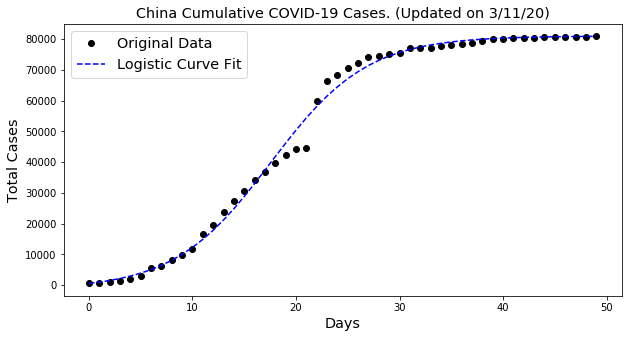



Italy

** Based on Logistic Fit **

	R^2: 0.998810491614
	Doubling Time:  2.69 (± 0.17 ) days

** Based on Exponential Curve Fit **

	R^2: 0.996683198353
	Doubling Time:  3.48 (± 0.14 ) days


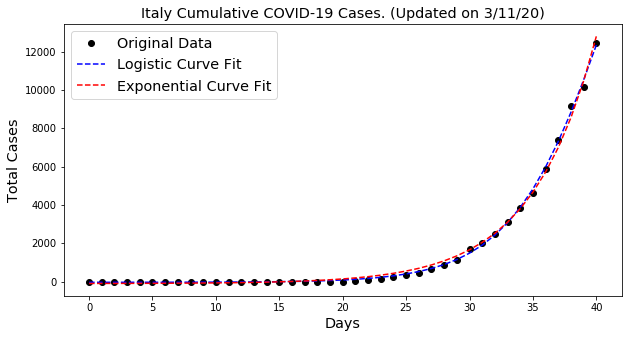



Iran

** Based on Logistic Fit **

	R^2: 0.998139240338
	Doubling Time:  1.82 (± 0.19 ) days


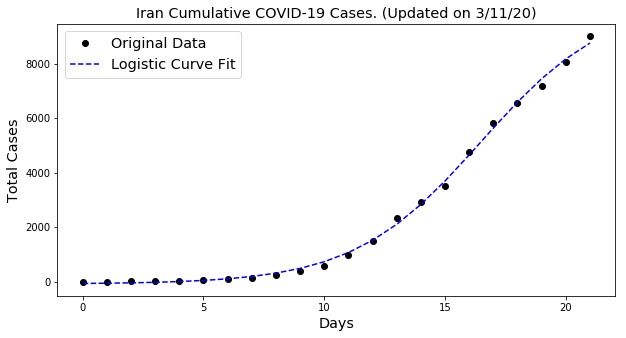



Korea, South

** Based on Logistic Fit **

	R^2: 0.999557647004
	Doubling Time:  1.95 (± 0.06 ) days


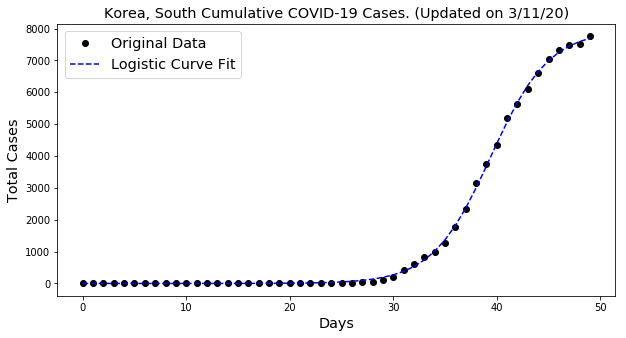



France

** Based on Exponential Curve Fit **

	R^2: 0.992523293743
	Doubling Time:  2.58 (± 0.13 ) days


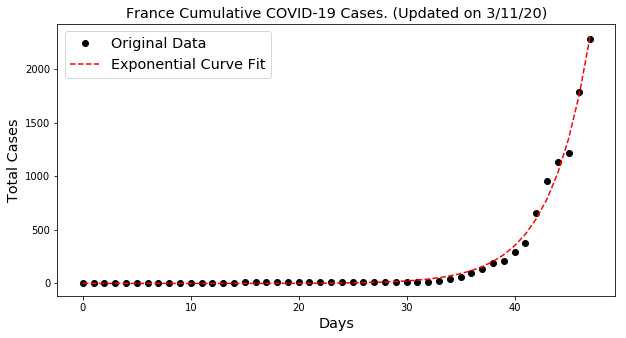



Spain

** Based on Exponential Curve Fit **

	R^2: 0.996845480178
	Doubling Time:  1.88 (± 0.07 ) days


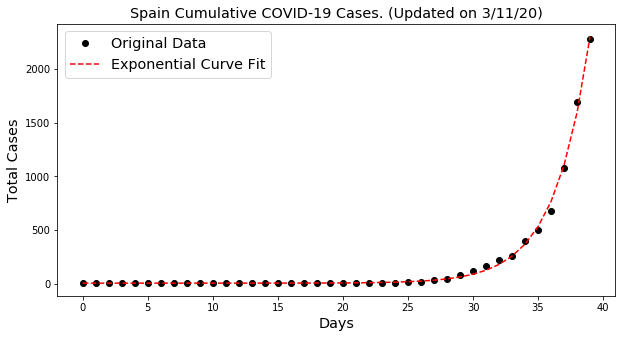



Germany

** Based on Exponential Curve Fit **

	R^2: 0.992019218235
	Doubling Time:  2.84 (± 0.16 ) days


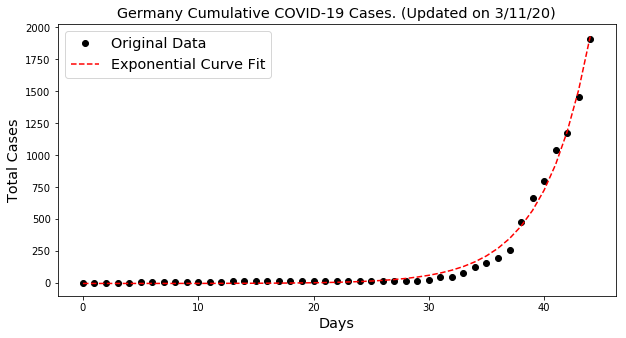



US

** Based on Exponential Curve Fit **

	R^2: 0.994160588626
	Doubling Time:  2.21 (± 0.1 ) days


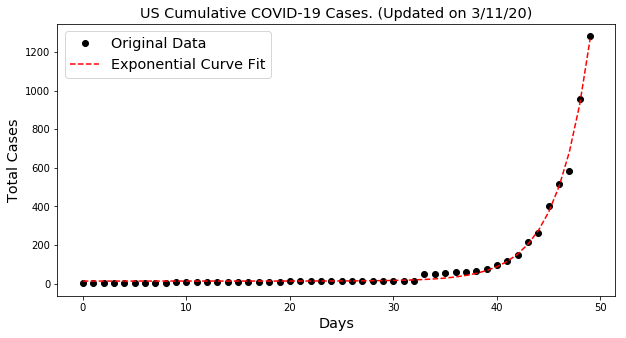



Cruise Ship

** Based on Logistic Fit **

	R^2: 0.995405853286
	Doubling Time:  1.35 (± 0.16 ) days


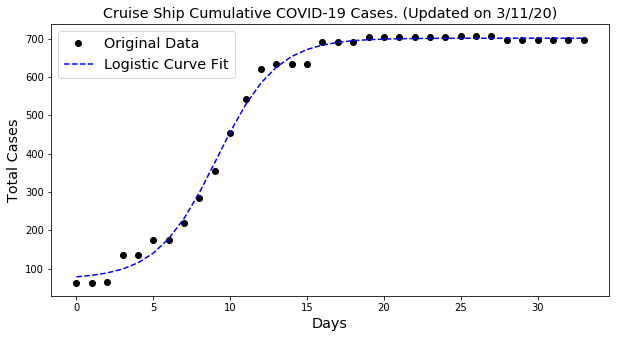



Switzerland

** Based on Logistic Fit **

	R^2: 0.992164612523
	Doubling Time:  2.47 (± 1.12 ) days

** Based on Exponential Curve Fit **

	R^2: 0.99168720806
	Doubling Time:  3.06 (± 0.43 ) days


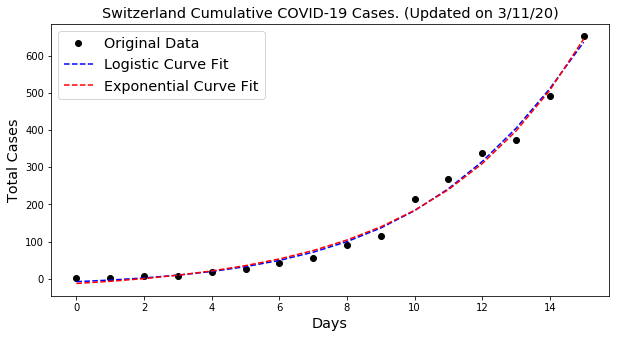



Japan

** Based on Logistic Fit **

	R^2: 0.996195323467
	Doubling Time:  6.79 (± 0.97 ) days

** Based on Exponential Curve Fit **

	R^2: 0.995911400127
	Doubling Time:  7.79 (± 0.36 ) days


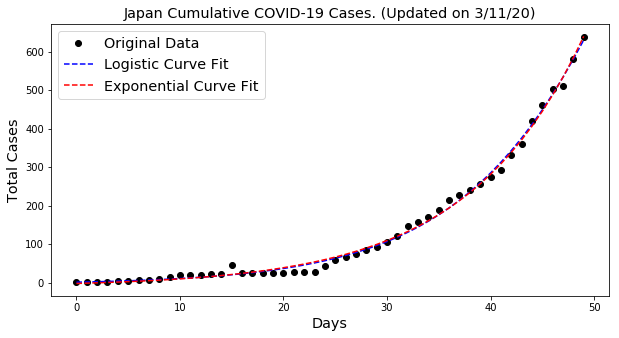



Norway

** Based on Logistic Fit **

	R^2: 0.984807405614
	Doubling Time:  1.68 (± 0.28 ) days

** Based on Exponential Curve Fit **

	R^2: 0.984807405919
	Doubling Time:  1.68 (± 0.27 ) days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


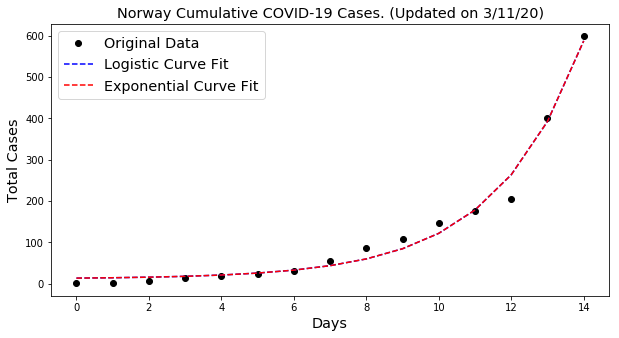



Netherlands

** Based on Logistic Fit **

	R^2: 0.995242663767
	Doubling Time:  1.62 (± 0.45 ) days

** Based on Exponential Curve Fit **

	R^2: 0.990240232642
	Doubling Time:  3.03 (± 0.54 ) days


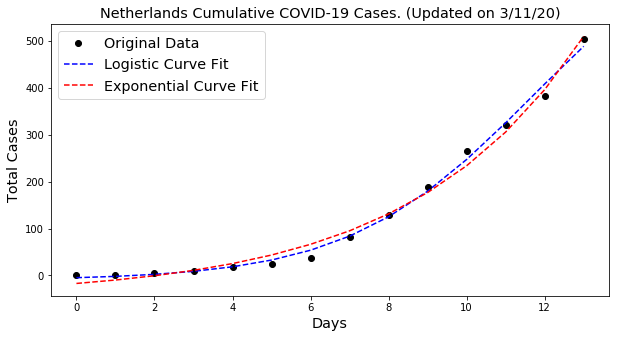



Sweden

** Based on Exponential Curve Fit **

	R^2: 0.994959570447
	Doubling Time:  2.18 (± 0.1 ) days


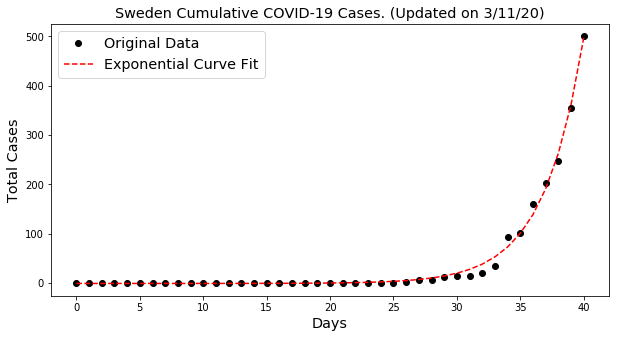



United Kingdom

** Based on Exponential Curve Fit **

	R^2: 0.990719796918
	Doubling Time:  2.98 (± 0.19 ) days


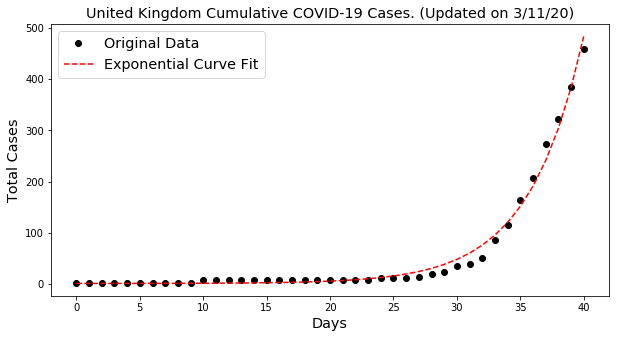



Denmark

** Based on Exponential Curve Fit **

	R^2: 0.988333164361
	Doubling Time:  1.0 (± 0.14 ) days


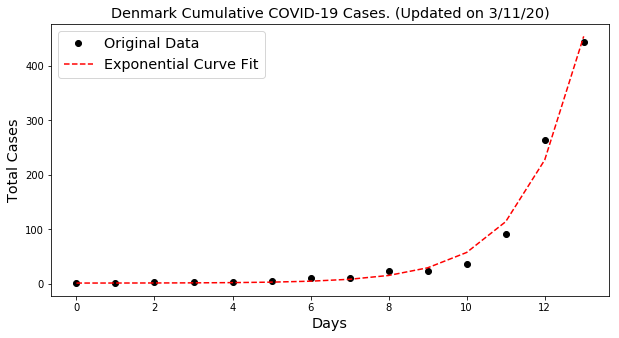



Belgium

** Based on Exponential Curve Fit **

	R^2: 0.959930662357
	Doubling Time:  2.79 (± 0.4 ) days


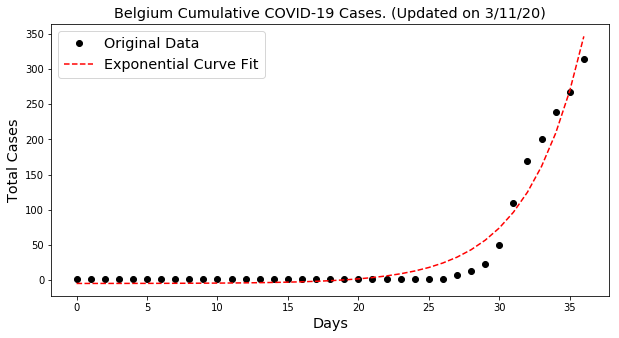



Qatar


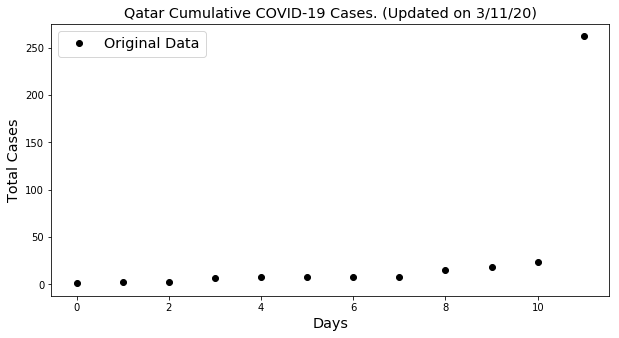



Austria

** Based on Logistic Fit **

	R^2: 0.999105103957
	Doubling Time:  2.39 (± nan ) days

** Based on Exponential Curve Fit **

	R^2: 0.999105104243
	Doubling Time:  2.39 (± 0.1 ) days


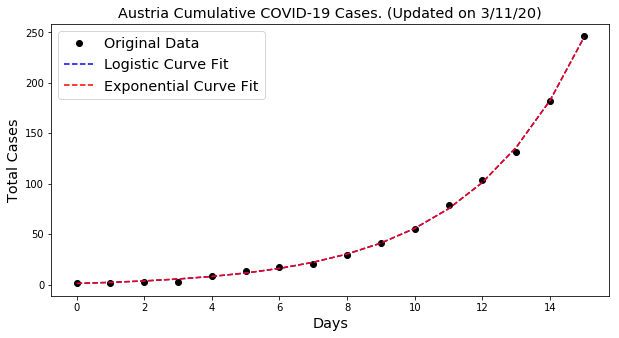



Bahrain


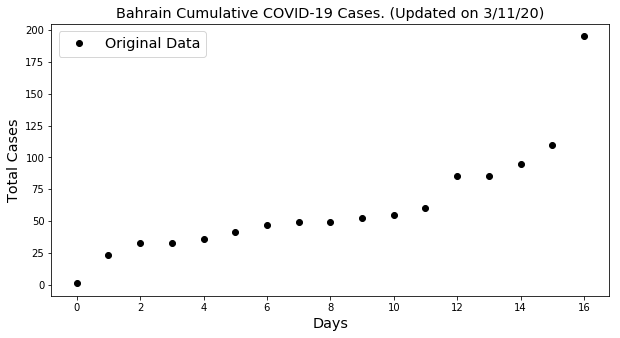



Singapore

** Based on Logistic Fit **

	R^2: 0.974909562764
	Doubling Time:  47.38 (± 104.65 ) days

** Based on Exponential Curve Fit **

	R^2: 0.973950197772
	Doubling Time:  34.91 (± 13.48 ) days


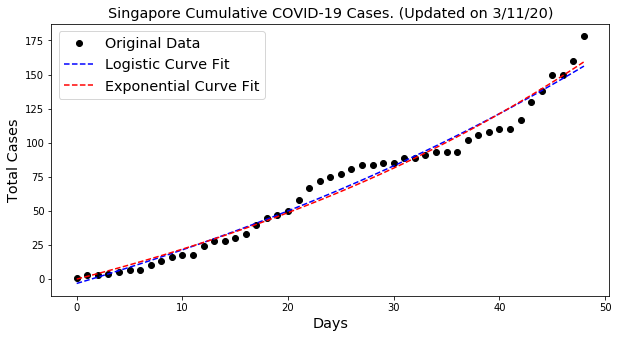



Malaysia

** Based on Exponential Curve Fit **

	R^2: 0.965826740476
	Doubling Time:  3.82 (± 0.45 ) days


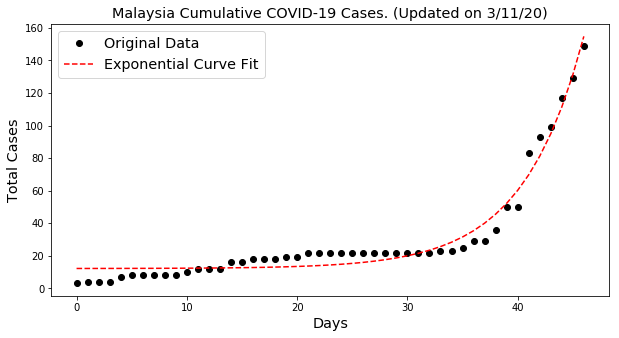



Australia

** Based on Exponential Curve Fit **

	R^2: 0.984497575247
	Doubling Time:  3.93 (± 0.31 ) days


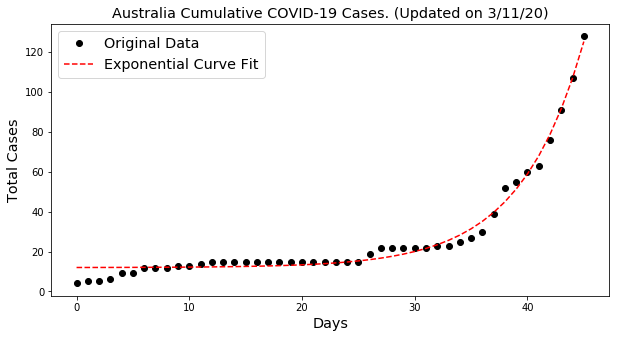



Israel

** Based on Logistic Fit **

	R^2: 0.989748937357
	Doubling Time:  2.46 (± 0.93 ) days

** Based on Exponential Curve Fit **

	R^2: 0.989303863434
	Doubling Time:  2.92 (± 0.35 ) days


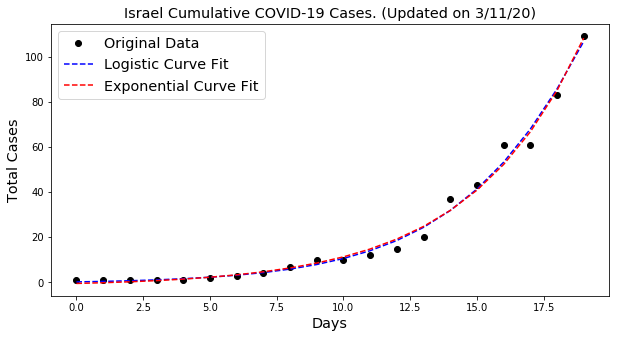



Canada

** Based on Exponential Curve Fit **

	R^2: 0.990924515895
	Doubling Time:  4.0 (± 0.24 ) days


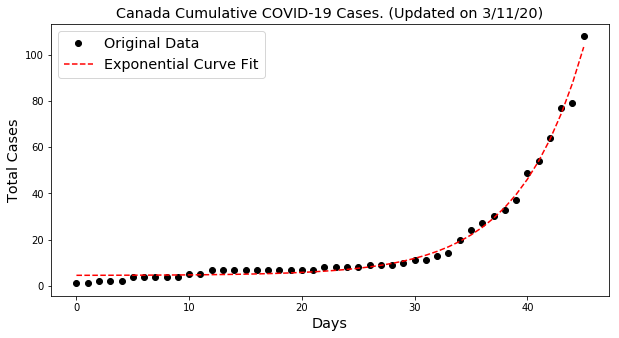

In [62]:
topcountries = cases.index
doublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        doublingtime.append(a[0])
        errors.append(a[1])
    print('\n')

## Doubling Times for Global COVID-19 Cases

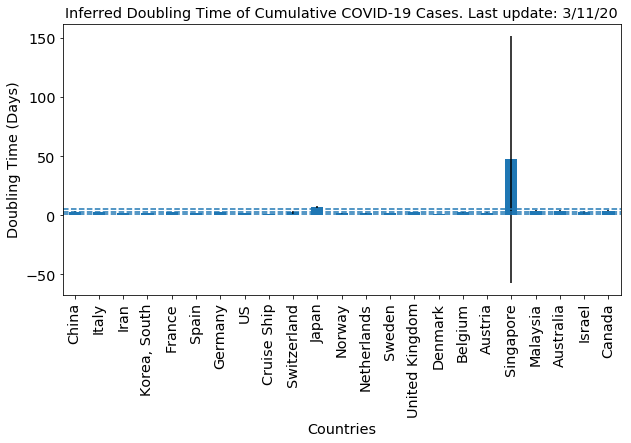

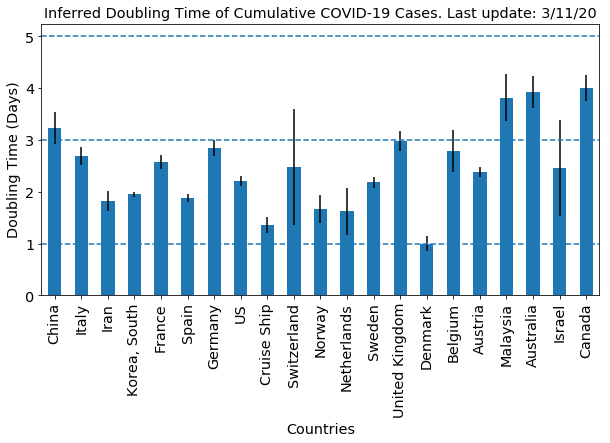

In [64]:
d = {'Countries': countries, 'Doubling Time': doublingtime, '95%CI': errors}

print('\n')
dt = pd.DataFrame(data = d)
dt.plot.bar(x = 'Countries', y = 'Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Doubling Time'] < 5]
dt.plot.bar(x = 'Countries', y = 'Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [67]:
uscases = df[df['Country/Region'] == 'US'].copy()

# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

for index, row in uscases.iterrows():
    location = row['Province/State']
    if ',' in location:
        result = [x.strip() for x in location.split(',')]
        statename = states[result[1]]
        row['State'] = statename
        uscases.loc[index, 'Province/State'] = statename

usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary


Number of confirmed US COVID-19 cases by state as of 3/11/20


,3/11/20
Province/State,
Washington,366
New York,220
California,177
Massachusetts,95
Diamond Princess,46
Colorado,34
Florida,28
Illinois,25
New Jersey,23


## Curve Fitting US COVID-19 Cases

                3/11/20
Province/State         
Washington          366
New York            220
California          177


US state:  Washington

** Based on Exponential Curve Fit **

	R^2: 0.979674336294
	Doubling Time:  1.98 (± 0.17 ) days


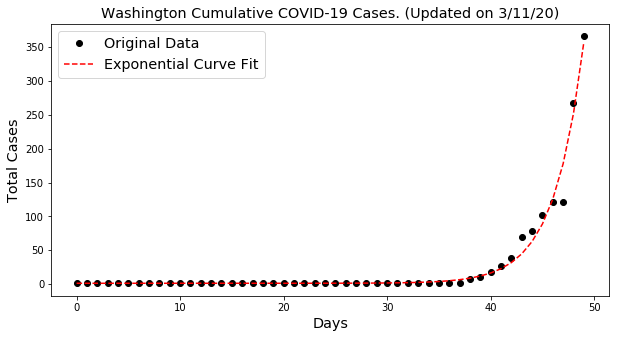



US state:  New York

** Based on Logistic Fit **

	R^2: 0.994915964693
	Doubling Time:  1.32 (± 0.52 ) days

** Based on Exponential Curve Fit **

	R^2: 0.988705361798
	Doubling Time:  3.49 (± 1.21 ) days


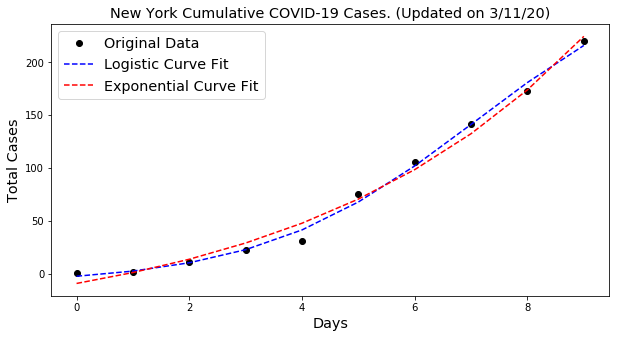



US state:  California

** Based on Exponential Curve Fit **

	R^2: 0.990789625296
	Doubling Time:  2.87 (± 0.17 ) days


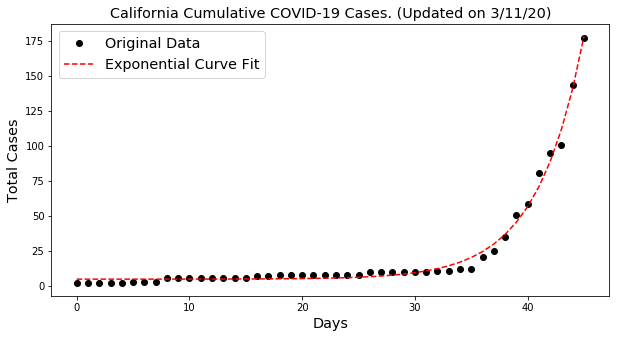

In [70]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
doublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        doublingtime.append(a[0])
        errors.append(a[1])
    print('\n')

## Doubling Times for US COVID-19 Cases

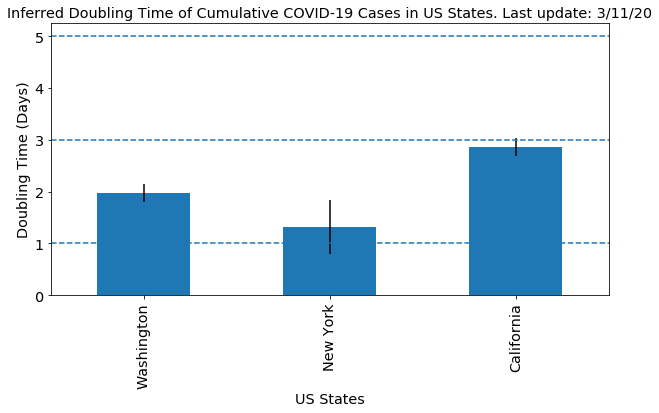

In [71]:
d = {'States': states, 'Doubling Time': doublingtime, '95%CI': errors}

print('\n')
dt = pd.DataFrame(data = d)
dt.plot.bar(x = 'States', y = 'Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()
